In [18]:
import re
import os
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# with open('../rfu_to_dilution.pkl','rb') as f:
#     rfu30_to_dilution = pickle.load(f)
#     f.close()

folder = '../experiment_data/max_death_rate_11072023'

exp_layout = {0:(0,['B','C','D']), # each genotype is associated with a tuple corresponding to the excel sheet number and the list of rows
              7:(0,['E','F','G']),
              11:(1,['B','C','D']),
              13:(1,['E','F','G']),
              14:(2,['B','C','D'])}

time = np.array([0,15,48,60,80,115,150,210,270,330])

rfu30_to_dilution = cal.run()

In [19]:
# takes a folder of excel files and returns a list of plates and a list of data
# each element in the list corresponds to a plate scan
# specify plate num to get the data from a specific excel sheet

def get_timeseries(folder_path,plate_num):
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [20]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,10))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            key = row + str(i+2) # col+2 because we start the experiment at col 2
            data_t[row_indx,i] = data[i][key]
            # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t)
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

# time = [element for i, element in enumerate(time) if i != 2]

cell_count_1103 = cell_count_mean
cell_count_1103_err = cell_count_err
cell_count_1103_log_err = cell_count_log_err
time_1103 = time

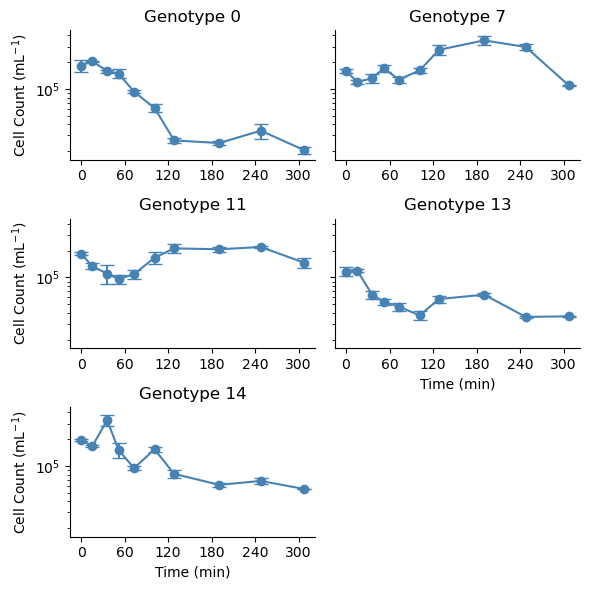

In [38]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,figsize=(6,6),sharey=True)
# fig,ax = plt.subplots()
ax_list = ax_list.flatten()

indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[indx]
    ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key],
                fmt='o',capsize=5,label=key, color='steelblue')
    
    ax.plot(time,cell_count_mean[key],color='steelblue')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_title('Genotype ' + str(key))
    
    indx+=1

ax_list[-1].remove()

for ax in ax_list[:-1]:
    ax.set_xticks(np.arange(0,np.max(time),60))

ax_list[0].set_ylabel('Cell Count (mL$^{-1}$)')
ax_list[2].set_ylabel('Cell Count (mL$^{-1}$)')
ax_list[4].set_ylabel('Cell Count (mL$^{-1}$)')

ax_list[4].set_xlabel('Time (min)')
ax_list[3].set_xlabel('Time (min)')

fig.tight_layout()

fig.savefig('../../figures/max_death_triple_mutants.pdf',bbox_inches='tight')

[[ 3.60085449e-03 -1.36465395e-10  1.79793174e-01]
 [-1.36465395e-10  1.17699620e-08 -2.28998018e-04]
 [ 1.79793174e-01 -2.28998018e-04  1.35724361e+01]]


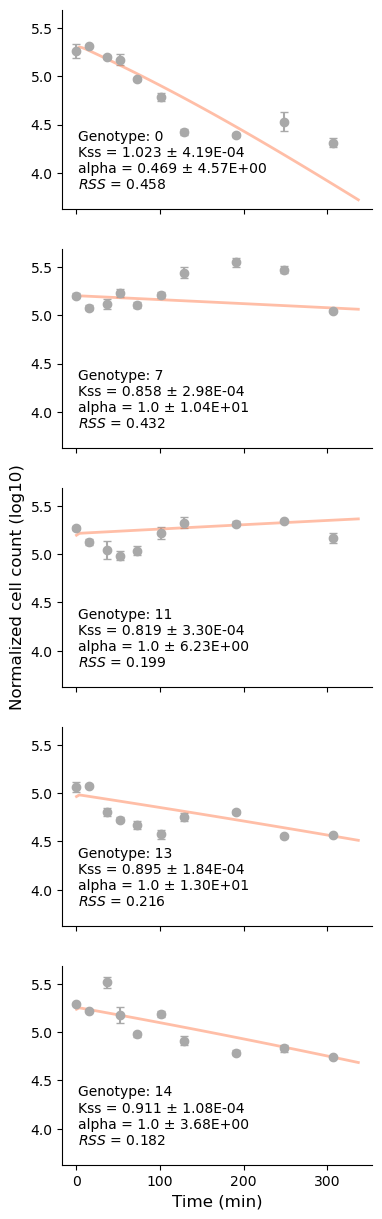

In [22]:
fig,ax_list = plt.subplots(nrows=5,figsize=(4,15),sharex=True,sharey=True)

cmap = mpl.colormaps['viridis']
def growth_diffeq(N,t,K,Kss,alpha,cc):

    dydt = (K-Kss*(1-np.exp(-alpha*t)))*N*(1-N/cc)

    return dydt

def growth_sol(t,y0,K,Kss,alpha,cc):
    y = odeint(growth_diffeq,y0,t,args=(K,Kss,alpha,cc))
    return y[:,0]

cc = 7
K = 0.014

xfit = np.linspace(0,np.max(time+30),100)

row_indx = 0

for key in cell_count_mean.keys():
    ax = ax_list[row_indx]

    y = np.log10(cell_count_mean[key])
    # y = y-y[0] + 3

    ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

    p0 = [2,0.1,0.1]
    bounds = [[1,0,0],[7,1,1]]

    popt,pcov = curve_fit(lambda time, y0, Kss, alpha: growth_sol(time,y0, K,Kss,alpha,cc),
                        time,y,p0=p0,maxfev=10000,bounds=bounds,sigma=cell_count_log_err[key])
    
    y0 = popt[0]
    Kss = popt[1]
    alpha = popt[2]
    yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

    resid = np.sum((y-growth_sol(time,y0,K,Kss,alpha,cc))**2)

    ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)

    err = np.sqrt(np.diag(pcov))

    ax.annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
                'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}" + '\n'
                '$RSS$ = ' + str(np.round(resid,3)), xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    row_indx += 1

ax_list[-1].set_xlabel('Time (min)',fontsize=12)
ax_list[2].set_ylabel('Normalized cell count (log10)',fontsize=12)

print(pcov)

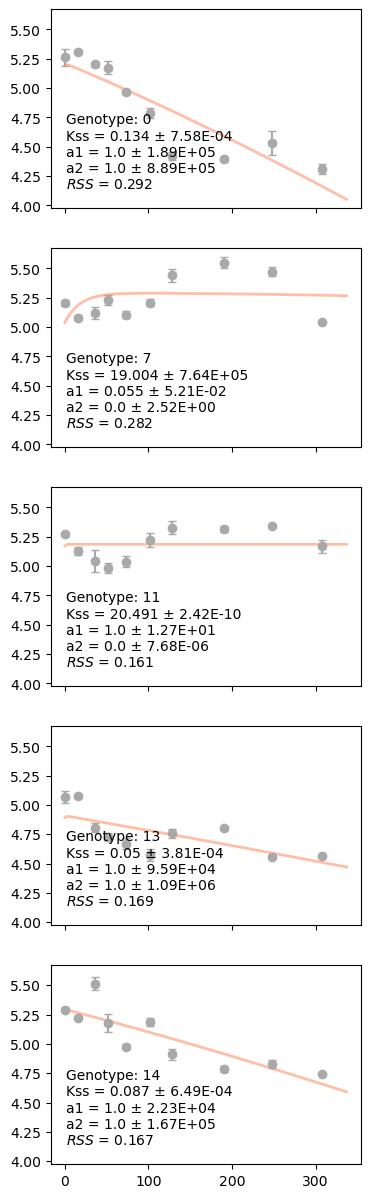

In [23]:
fig,ax_list = plt.subplots(nrows=5,figsize=(4,15),sharex=True,sharey=True)

def growth_diffeq(N,t,K,Kss,a1,a2,cc):

    # dydt = (K-Kss*(1-np.exp(-alpha*t)))*N*(1-N/cc)
    dydt = (K*np.exp(-a1*t)-Kss*(1- np.exp(-a2*t))*N*(1-N/cc))

    return dydt

def growth_sol(t,y0,K,Kss,a1,a2,cc):
    y = odeint(growth_diffeq,y0,t,args=(K,Kss,a1,a2,cc))
    return y[:,0]

a1 = .01
a2 = 0.01
cc = 7
y0 = 5
K = 1/60
Kss = 1.5/60

cc = 7
K = 0.014

xfit = np.linspace(0,np.max(time+30),100)

row_indx = 0

for key in cell_count_mean.keys():
    ax = ax_list[row_indx]

    y = np.log10(cell_count_mean[key])
    # y = y-y[0] + 3

    ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

    p0 = [6,0.1,0.01,0.001]
    bounds = [[1,0,0,0],[7,1,1,1]]

    popt,pcov = curve_fit(lambda time, y0, Kss, a1, a2: growth_sol(time,y0, K,Kss,a1,a2,cc),
                        time,y,p0=p0,maxfev=10000,bounds=bounds)
    
    y0 = popt[0]
    Kss = popt[1]
    a1 = popt[2]
    a2 = popt[3]
    err = np.sqrt(np.diag(pcov))

    resid = np.sum((y-growth_sol(time,y0,K,Kss,a1,a2,cc))**2)

    yfit = growth_sol(xfit,y0,K,Kss,a1,a2,cc)

    ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)

    ax.annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
                'a1 = ' + str(np.round(a1,3)) + " ± " + f"{err[2]:.2E}" + '\n' + 'a2 = ' + str(np.round(a2,3)) + " ± " + f"{err[3]:.2E}" + 
                '\n' + '$RSS$ = ' + str(np.round(resid,3))
                , xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
    row_indx += 1

In [24]:
print(pcov)

[[ 2.78702697e-02 -4.69233995e-10  2.01486559e+00 -1.66847442e-01]
 [-4.69233995e-10  4.21657683e-07 -1.13500345e+01  8.48085127e+01]
 [ 2.01486559e+00 -1.13500345e+01  4.98670858e+08 -3.72679815e+09]
 [-1.66847442e-01  8.48085127e+01 -3.72679815e+09  2.78520978e+10]]
